In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML


2025-05-12 17:02:34.195850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747069354.406637      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747069354.462360      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_DIM = 256
COLOR_CHANNELS = 3
BATCH_COUNT = 32
TOTAL_EPOCHS = 50

DATA_ROOT = "/kaggle/input/pepper-bell-dataset"


In [3]:
image_data = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_ROOT,
    seed=42,
    image_size=(IMG_DIM, IMG_DIM),
    batch_size=BATCH_COUNT,
    shuffle=True
)


Found 2475 files belonging to 2 classes.


I0000 00:00:1747069403.228630      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747069403.229388      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [5]:
label_names = image_data.class_names
label_names


['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [6]:
for batch_images, batch_labels in image_data.take(1):
    print(f"Image batch shape: {batch_images.shape}")
    print("Label values:", batch_labels.numpy())


(32, 256, 256, 3)
[1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1]


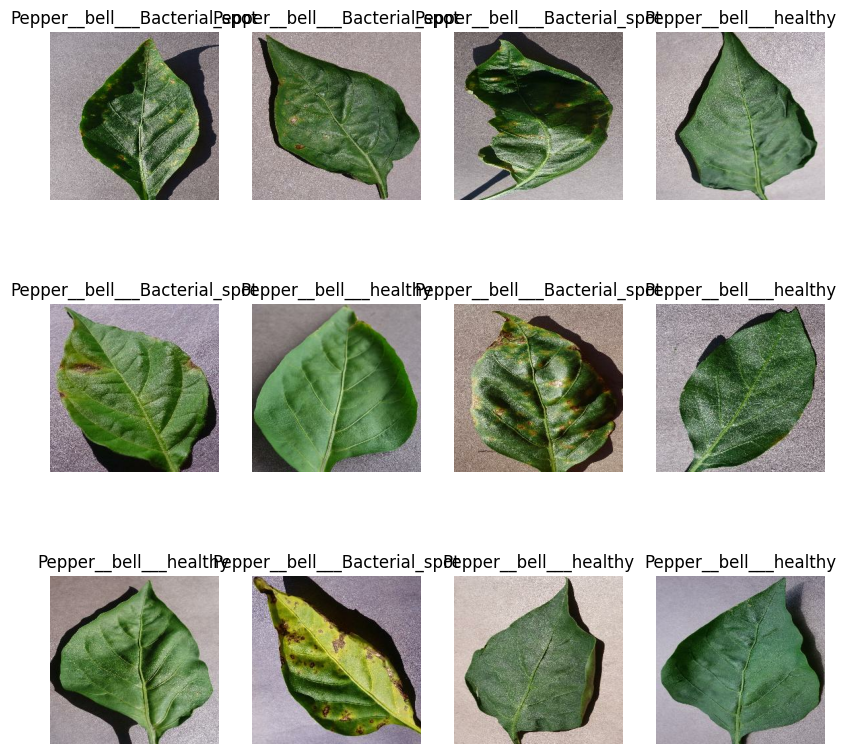

In [7]:
plt.figure(figsize=(11, 9))
sample_batch = next(iter(image_data))

for idx in range(12):
    subplot_axis = plt.subplot(3, 4, idx + 1)
    img = sample_batch[0][idx].numpy().astype("uint8")
    label = sample_batch[1][idx]
    
    plt.imshow(img)
    plt.title(label_names[label])
    plt.axis("off")

plt.tight_layout()
plt.show()


In [8]:
def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, randomize=True, buffer_size=10000):
    assert round(train_ratio + val_ratio + test_ratio, 2) == 1.0, "Split ratios must sum to 1."

    full_size = len(dataset)

    if randomize:
        dataset = dataset.shuffle(buffer_size, seed=99)

    train_count = int(train_ratio * full_size)
    val_count = int(val_ratio * full_size)

    train_data = dataset.take(train_count)
    val_data = dataset.skip(train_count).take(val_count)
    test_data = dataset.skip(train_count + val_count)

    return train_data, val_data, test_data


In [9]:
train_data, val_data, test_data = split_dataset(image_data)


In [10]:
print(f"Training batches: {len(train_data)}")
print(f"Validation batches: {len(val_data)}")
print(f"Testing batches: {len(test_data)}")


(62, 7, 9)

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)


In [12]:
from tensorflow.keras import layers, Sequential

# Resize to target dimension and normalize pixel values
preprocessing_pipeline = Sequential([
    layers.Resizing(IMG_DIM, IMG_DIM),
    layers.Rescaling(1.0 / 255)
])


In [13]:
augmentation_block = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])


In [14]:
train_data = train_data.map(
    lambda img, label: (augmentation_block(img, training=True), label)
).prefetch(tf.data.AUTOTUNE)


In [15]:
from tensorflow.keras import models

input_dims = (IMG_DIM, IMG_DIM, COLOR_CHANNELS)
total_classes = 3  # number of categories

cnn_model = models.Sequential([
    layers.Input(batch_shape=(BATCH_COUNT, *input_dims)),

    preprocessing_pipeline,

    layers.Conv2D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),

    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),

    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),

    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),

    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),

    layers.Conv2D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(total_classes, activation='softmax')
])


In [16]:
cnn_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
cnn_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [18]:
training_log = cnn_model.fit(
    train_data,
    batch_size=BATCH_COUNT,
    validation_data=val_data,
    epochs=15,
    verbose=1
)


Epoch 1/15


I0000 00:00:1747069491.589693      97 service.cc:148] XLA service 0x7a5e340a8160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747069491.590811      97 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747069491.590832      97 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747069492.005069      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/62 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7734 - loss: 1.0529  

I0000 00:00:1747069497.591674      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 449ms/step - accuracy: 0.5894 - loss: 0.7770 - val_accuracy: 0.5982 - val_loss: 0.6837
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - accuracy: 0.6940 - loss: 0.5897 - val_accuracy: 0.8973 - val_loss: 0.3890
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 331ms/step - accuracy: 0.8714 - loss: 0.3434 - val_accuracy: 0.9375 - val_loss: 0.2958
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 338ms/step - accuracy: 0.9550 - loss: 0.1458 - val_accuracy: 0.9732 - val_loss: 0.1535
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 337ms/step - accuracy: 0.9836 - loss: 0.0606 - val_accuracy: 0.9911 - val_loss: 0.0595
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 341ms/step - accuracy: 0.9881 - loss: 0.0355 - val_accuracy: 0.9911 - val_loss: 0.0578
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 335ms/step - accuracy: 0.9881 - loss: 0.0454 - val_accuracy: 0.9911 - val_loss: 0.0454
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 332ms/step - accuracy: 0.9913 - loss: 0.0328 - val_accuracy: 0.995

In [19]:
# Redundant compilation for safety, can be removed
cnn_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [38]:
test_metrics = cnn_model.evaluate(test_data)
print(f"Test Accuracy: {test_metrics[1]:.4f}")


Test Accuracy: 98.3212


In [21]:
scores


[0.01258829329162836, 1.0]

In [22]:
history


In [23]:
history.params


{'verbose': 1, 'epochs': 15, 'steps': 62}

In [24]:
# View metrics captured during training
list(training_log.history.keys())


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [25]:
# Check the data type of loss values
type(training_log.history["loss"])


list

In [26]:
# Print initial few epochs of loss values
training_log.history["loss"][:5]


[0.7128734588623047,
 0.5061026215553284,
 0.30282062292099,
 0.1379346400499344,
 0.059651751071214676]

In [27]:
# Assign metrics to clearly named variables
train_accuracy = training_log.history["accuracy"]
valid_accuracy = training_log.history["val_accuracy"]
train_loss = training_log.history["loss"]
valid_loss = training_log.history["val_loss"]


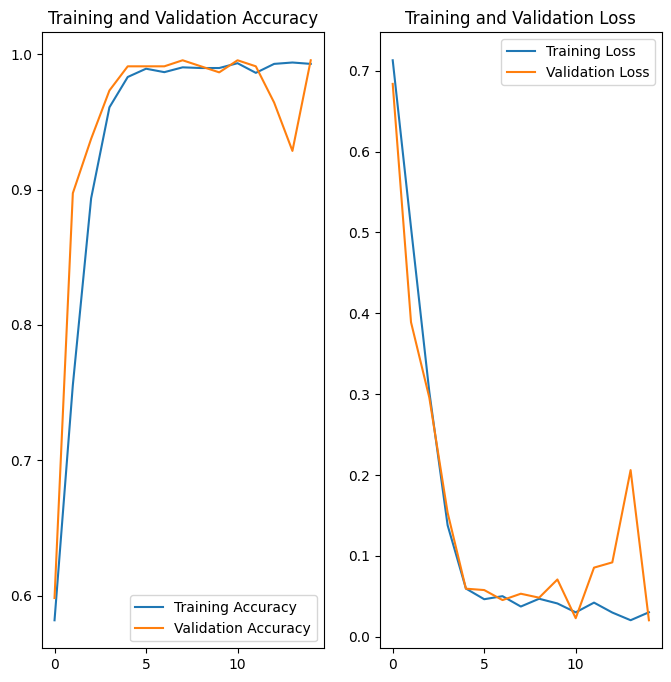

In [28]:
# Epoch range
epochs_range = range(len(train_accuracy))

plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy, label="Train Acc")
plt.plot(epochs_range, valid_accuracy, label="Val Acc")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label="Train Loss")
plt.plot(epochs_range, valid_loss, label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


first image to predict
actual label: Pepper__bell___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
predicted label: Pepper__bell___healthy


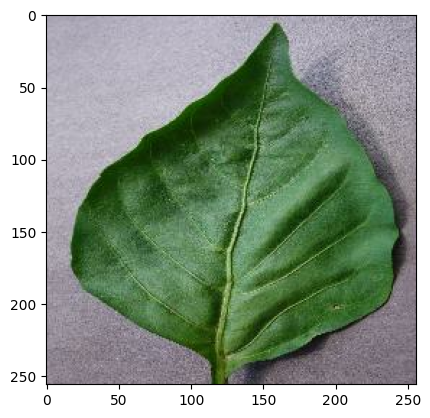

In [29]:
import numpy as np

for sample_images, sample_labels in test_data.take(1):
    img_array = sample_images[0].numpy().astype("uint8")
    true_class = sample_labels[0].numpy()

    print("Visualizing test image for prediction...")
    plt.imshow(img_array)
    plt.axis("off")
    print("Ground truth label:", label_names[true_class])

    prediction_output = cnn_model.predict(sample_images)
    predicted_class = np.argmax(prediction_output[0])
    print("Model predicted label:", label_names[predicted_class])


In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


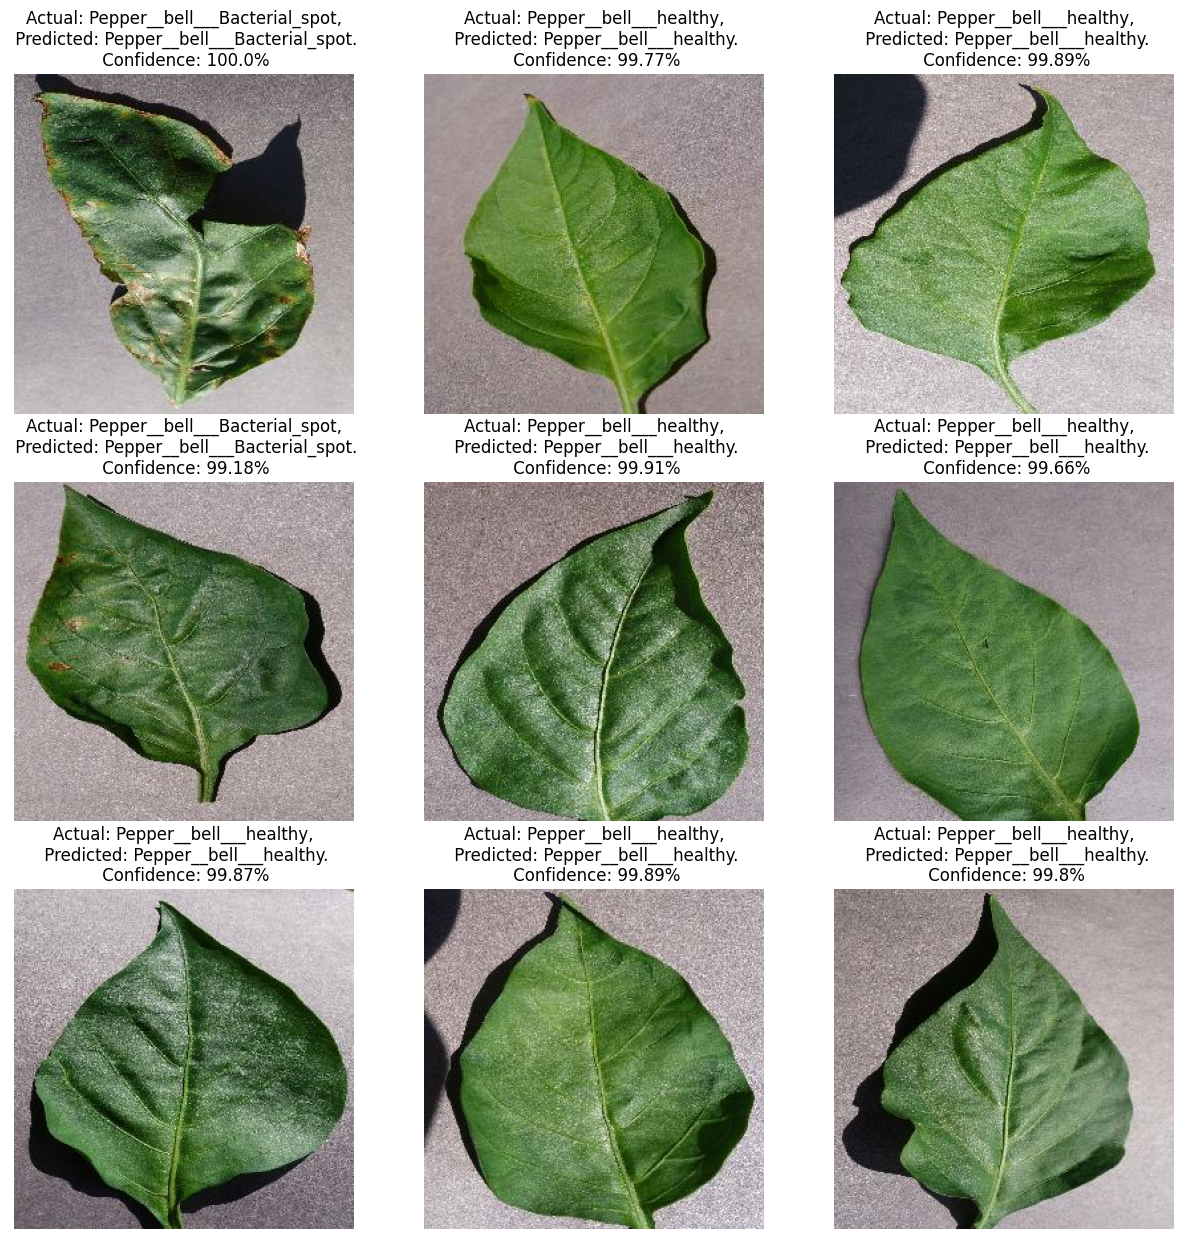

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")
